In [28]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [1]:
vocab_size = 10000
embedding_dim = 20
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [2]:
!wget --no-check-certificate \  # get the training dataset from my github repo
    https://raw.githubusercontent.com/prikarsartam/training_datasets/main/sarcasm_dataset.json \
    -O sarcasm_classifier_dataset.json


--2022-08-30 20:50:36--  https://raw.githubusercontent.com/prikarsartam/training_datasets/main/sarcasm_dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6057046 (5.8M) [text/plain]
Saving to: ‘sarcasm_classifier_dataset.json’

sarcasm_classifier_ 100%[===================>]   5.78M  --.-KB/s    in 0.04s   

2022-08-30 20:50:36 (164 MB/s) - ‘sarcasm_classifier_dataset.json’ saved [6057046/6057046]



In [6]:
datastore = [json.loads(line) for line in open('sarcasm_classifier_dataset.json', 'r')]

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [14]:
# non LSTM model with comparetively LOW number of parameters 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 20)           200000    
                                                                 
 global_average_pooling1d_1   (None, 20)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                504       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 200,529
Trainable params: 200,529
Non-trainable params: 0
_________________________________________________________________


In [16]:
# LSTM model with comparetively HIGH number of parameters 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 20)           200000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              43520     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 251,841
Trainable params: 251,841
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 80s - loss: 0.4038 - accuracy: 0.8029 - val_loss: 0.3159 - val_accuracy: 0.8581 - 80s/epoch - 129ms/step
Epoch 2/30
625/625 - 72s - loss: 0.2094 - accuracy: 0.9151 - val_loss: 0.3342 - val_accuracy: 0.8550 - 72s/epoch - 115ms/step
Epoch 3/30
625/625 - 71s - loss: 0.1230 - accuracy: 0.9542 - val_loss: 0.3954 - val_accuracy: 0.8510 - 71s/epoch - 113ms/step
Epoch 4/30
625/625 - 72s - loss: 0.0730 - accuracy: 0.9746 - val_loss: 0.4834 - val_accuracy: 0.8479 - 72s/epoch - 116ms/step
Epoch 5/30
625/625 - 72s - loss: 0.0425 - accuracy: 0.9857 - val_loss: 0.6385 - val_accuracy: 0.8414 - 72s/epoch - 115ms/step
Epoch 6/30
625/625 - 71s - loss: 0.0282 - accuracy: 0.9908 - val_loss: 0.6773 - val_accuracy: 0.8405 - 71s/epoch - 113ms/step
Epoch 7/30
625/625 - 72s - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.9964 - val_accuracy: 0.8311 - 72s/epoch - 116ms/step
Epoch 8/30
625/625 - 72s - loss: 0.0164 - accuracy: 0.9939 - val_loss: 0.9769 - val_accuracy: 0.8376 - 72s/epoch - 115

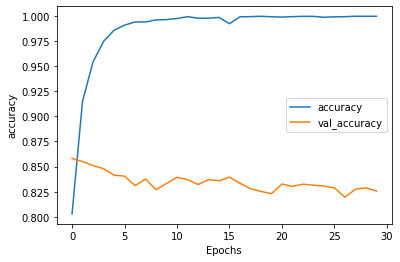

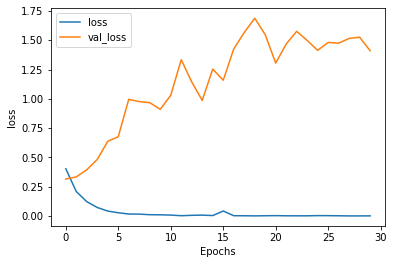

In [18]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
eat your veggies: 9 deliciously different recipes
0


In [20]:
e = model.layers[0]
weights = e.get_weights()[0]

print(weights)

print(weights.shape) # shape: (vocab_size, embedding_dim)

[[-0.00552408  0.05878906  0.00401659 ... -0.01009426 -0.00782012
  -0.10627296]
 [ 0.01552948 -0.00410151 -0.0289727  ... -0.00890093  0.02420226
   0.00483764]
 [ 0.07627809 -0.00253337  0.01737423 ...  0.06715222  0.0652498
   0.04161514]
 ...
 [-0.10940222  0.01587684 -0.03893879 ... -0.08364195 -0.06136721
   0.00168721]
 [ 0.04797405 -0.12345733 -0.09139848 ...  0.0758003   0.01523671
   0.06569206]
 [ 0.04817487 -0.12695833 -0.09506658 ...  0.02994963 -0.06340925
   0.04729394]]
(10000, 20)


In [21]:
e = model.layers[0]
weights = e.get_weights()[0]

print(weights)

print(weights.shape) # shape: (vocab_size, embedding_dim)

[[-0.00552408  0.05878906  0.00401659 ... -0.01009426 -0.00782012
  -0.10627296]
 [ 0.01552948 -0.00410151 -0.0289727  ... -0.00890093  0.02420226
   0.00483764]
 [ 0.07627809 -0.00253337  0.01737423 ...  0.06715222  0.0652498
   0.04161514]
 ...
 [-0.10940222  0.01587684 -0.03893879 ... -0.08364195 -0.06136721
   0.00168721]
 [ 0.04797405 -0.12345733 -0.09139848 ...  0.0758003   0.01523671
   0.06569206]
 [ 0.04817487 -0.12695833 -0.09506658 ...  0.02994963 -0.06340925
   0.04729394]]
(10000, 20)


In [22]:
import io

out_v = io.open('vecs.json', 'w', encoding='utf-8')
out_m = io.open('meta.json', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [23]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.json')
  files.download('meta.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
no_of_sentences = int(input("Enter the number of sentences you want as input: "))

sentence = []

for i in range(0,no_of_sentences):
  sentence.append(str(input("Enter sentence: ")))

print("\n\n")

# sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))



Enter the number of sentences you want as input: 2
Enter sentence: fuckers suck
Enter sentence: suckers fuck
[[0.9997004]
 [0.9999906]]


In [26]:
from tensorflow.keras.models import load_model

In [27]:
model.save('/content/drive/MyDrive/sarcasm_classifier_model/sarcasm_classifier_model.h5')